In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import os
from tqdm import tqdm
import pickle

from IPython.display import display
%matplotlib inline
matplotlib.style.use('ggplot')

In [36]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 100
# BATCH_SIZE = 100
LEARNING_RATE = 0.03
NUMBER_OF_NEURONS = 512
REGULARIZATION_LAMBDA = 0.1

In [37]:
# UTILS
def sigmoid(x):
    return np.multiply(0.5, (1 + np.tanh(np.multiply(0.5, x))))


def relu(x):
    return x.clip(min=0)


def sigmoid_derivative(x):
    return np.multiply(x, (1 - x))


def relu_derivative(x):
    x[x > 0] = 1
    x[x <= 0] = 0
    return x


def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]


def split_data(dataset, train_size=0.8):
    if isinstance(dataset, pd.core.frame.DataFrame):
        dataset = dataset.sample(frac=1)
    elif isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Pandas DataFrame required.')

    size = dataset.shape[0]
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]


def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array required.')

    return np.array_split(dataset, k)


def get_under_sample_dataset(dataset, train_and_validation):
    fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
    normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)
    random_normal_indices = np.array(np.random.choice(normal_indices, fraud_indices.shape[0], replace=False))
    under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    return dataset.iloc[under_sample_indices, :].sample(frac=1)


def plot_loss(epochs, training_history, validation_history):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, training_history, label='train_loss')
    ax.plot(x_axis, validation_history, label='val_loss')
    ax.legend()
    plt.ylabel('MSE')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    plt.show()


def plot_confusion_matrix(model, x, y):
    predicted = np.round(model.predict(x)).reshape(-1, )
    actual = y.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns=['actual 1', 'actual 0'],
                                    index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)

    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print('\n')
    print(confusion_matrix)
    
    
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    


In [38]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
assert not dataset.isnull().values.any()
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

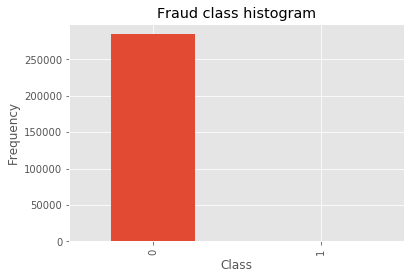

0    284315
1       492
Name: Class, dtype: int64

In [39]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [40]:
# Split dataset on train_and_validation dataset and test dataset
# train_and_validation, test = split_data(dataset, train_size=0.8)


In [41]:
# export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("..", "data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("..", "data", "test_dataset.data"), "wb" ))


In [42]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("..", "data", "train_and_validation_dataset.data"), "rb" ))


In [43]:
# Create balanced, under sample train and validation dataset 
under_sample_dataset = get_under_sample_dataset(dataset, train_and_validation)


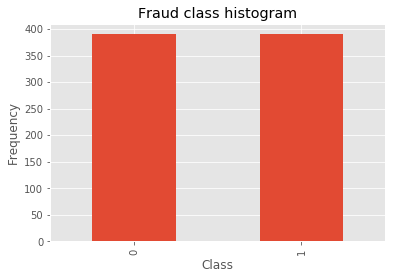

0    390
1    390
Name: Class, dtype: int64

In [44]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [45]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [46]:
class Layer:
    def __init__(self, input_dim, neurons_number, learning_rate, activation):
        self.activation = activation
        self.learning_rate = learning_rate

        self.output_layer = True

        self.input = np.asmatrix(np.zeros((input_dim + 1, 1)))
        self.output = np.asmatrix(np.zeros((neurons_number, 1)))
        self.weights = np.asmatrix(np.random.uniform(low=-2/(input_dim**0.5), high=2/(input_dim**0.5), size=(input_dim + 1, neurons_number)))
        self.deltas = np.asmatrix(np.zeros((neurons_number, 1)))
        self.cumulative_gradient = np.asmatrix(np.zeros((input_dim + 1, neurons_number)))

    def _activate(self, x):
        if self.activation == 'sigmoid':
            return sigmoid(x)
        elif self.activation == 'relu':
            return relu(x)

    def _get_gradient(self):
        return np.matmul(self.input, self.deltas.transpose())

    def forward_step(self, input_data):
        self.input = np.concatenate([[[1]], input_data])  # Add bias
        self.output = self._activate(np.matmul(self.weights.transpose(), self.input))
        return self.output

    def backward_step(self, next_weights=None, next_deltas=None, output_delta=None):
        if self.output_layer:
            self.deltas = output_delta
        else:
            derivative_of_activation = self.get_activation_derivative(self.output)
            self.deltas = np.multiply(np.matmul(np.delete(next_weights, 0, 0), next_deltas),
                                      derivative_of_activation)  # Exclude bias row from weights

        self.cumulative_gradient = self.cumulative_gradient + self._get_gradient()

    def get_activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return sigmoid_derivative(x)
        elif self.activation == 'relu':
            return relu_derivative(x)

    def get_deltas(self):
        return self.deltas

    def get_weights(self):
        return self.weights


class NeuralNetwork:
    def __init__(self, learning_rate, batch_size=50, epochs=20, loss='mse', regular_lambda=0.1):
        self.layers = []
        self.lerning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.loss = loss
        self.regular_lambda = regular_lambda

        self.training_history = []
        self.validation_history = []

    def _global_forward_step(self, x_train_batch):
        y_predicted_batch = []
        for x_train_record in x_train_batch:
            x_train_record = x_train_record.reshape((-1, 1))
            for layer in self.layers:
                x_train_record = layer.forward_step(x_train_record)
            y_predicted_batch.append(x_train_record)

        return np.concatenate(y_predicted_batch)

    def _global_backward_step(self, y_predicted_record, y_train_record):

        output_delta = self._count_output_delta(y_predicted_record, y_train_record)

        output_layer = self.layers[-1]
        output_layer.backward_step(output_delta=output_delta)

        next_deltas = output_layer.get_deltas()
        next_weights = output_layer.get_weights()

        for layer in reversed(self.layers[:-1]):
            layer.backward_step(next_weights=next_weights, next_deltas=next_deltas)

    def _count_output_delta(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.sum(np.multiply((y_predicted - y_actual), self.layers[-1].get_activation_derivative(y_predicted)), axis=0)

    def _save_loss(self, x_tr, y_tr, x_val, y_val):
        y_predicted_train = self._global_forward_step(x_tr)
        train_loss = self._count_loss(y_predicted_train, y_tr)
        self.training_history.append(train_loss)

        if x_val is not None and y_val is not None:
            y_predicted_validation = self._global_forward_step(x_val)
            validation_loss = self._count_loss(y_predicted_validation, y_val)
            self.validation_history.append(validation_loss)
            
        print("Loss: ", train_loss, " Accuracy: ", accuracy_score(y_tr, np.round(y_predicted_train)))


    def _count_loss(self, y_predicted, y_actual):
        if self.loss == 'mse':
            return np.average(np.square(y_actual - y_predicted))

    def add_layer(self, input_dim, neurons_number, activation='sigmoid'):
        layer = Layer(input_dim, neurons_number, learning_rate=self.lerning_rate, activation=activation)
        if self.layers:
            self.layers[-1].output_layer = False
        self.layers.append(layer)

    def fit(self, x_tr, y_tr, x_val=None, y_val=None):
        for i in range(self.epochs):
            for idx in range(0, x_tr.shape[0], self.batch_size):
                x_train_batch = x_tr[idx:idx + self.batch_size]
                y_train_batch = y_tr[idx:idx + self.batch_size]

                for n, x_train_record in enumerate(x_train_batch):
                    x_train_record = x_train_record.reshape(1, -1)
                    y_predicted_record = self._global_forward_step(x_train_record)
                    self._global_backward_step(y_predicted_record, y_train_batch[n])

                for lyr in self.layers:
                    gradient = lyr.cumulative_gradient / x_train_batch.shape[0] + self.regular_lambda * lyr.weights
                    lyr.weights = lyr.weights - np.multiply(self.lerning_rate, gradient)
                    lyr.cumulative_gradient = np.asmatrix(np.zeros(lyr.cumulative_gradient.shape))
            self._save_loss(x_tr, y_tr, x_val, y_val)

    def predict(self, x):
        return self._global_forward_step(x)

    def evaluate(self, x, y):
        y_predicted = self._global_forward_step(x)
        loss = self._count_loss(y_predicted, y)

        print("Loss: ", loss)
        print("Accuracy: ", accuracy_score(y, np.round(y_predicted)))

In [47]:
# k-fold validation with k=5
k_fold_split_array = k_fold_split_data(under_sample_dataset, N_SPLITS)
models = []
for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = train[:, :-1]
    y_train = train[:, -1:]

    x_validation = validation[:, :-1]
    y_validation = validation[:, -1:]

    model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
    model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
    model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
    model.fit(x_train, y_train, x_validation, y_validation)
    
    print("\n", '='*80)
    print("Validation dataset evaluation:")
    model.evaluate(x_validation, y_validation)
    print("\n")
    models.append(model)

Loss:  0.184559750278  Accuracy:  0.6730769230769231
Loss:  0.173284980755  Accuracy:  0.6875
Loss:  0.164044716214  Accuracy:  0.7115384615384616
Loss:  0.156332720444  Accuracy:  0.7435897435897436
Loss:  0.149429705705  Accuracy:  0.7564102564102564
Loss:  0.1432526972  Accuracy:  0.7724358974358975
Loss:  0.137733656026  Accuracy:  0.7868589743589743
Loss:  0.132803863703  Accuracy:  0.7980769230769231
Loss:  0.128395353044  Accuracy:  0.8108974358974359
Loss:  0.124443377832  Accuracy:  0.8221153846153846
Loss:  0.1208885525  Accuracy:  0.8269230769230769
Loss:  0.117678078717  Accuracy:  0.8365384615384616
Loss:  0.114766115528  Accuracy:  0.842948717948718
Loss:  0.112113500297  Accuracy:  0.8509615384615384
Loss:  0.109686982876  Accuracy:  0.8605769230769231
Loss:  0.107458443234  Accuracy:  0.8621794871794872
Loss:  0.105404122325  Accuracy:  0.8637820512820513
Loss:  0.103503870137  Accuracy:  0.8685897435897436
Loss:  0.101740506338  Accuracy:  0.8766025641025641
Loss:  0.1

Loss:  0.0724382873774  Accuracy:  0.9262820512820513
Loss:  0.0721898005149  Accuracy:  0.9262820512820513
Loss:  0.0719504711119  Accuracy:  0.9262820512820513
Loss:  0.071719894732  Accuracy:  0.9262820512820513
Loss:  0.0714976919865  Accuracy:  0.9262820512820513
Loss:  0.0712835154355  Accuracy:  0.9262820512820513
Loss:  0.0710770315765  Accuracy:  0.9262820512820513
Loss:  0.0708779279487  Accuracy:  0.9262820512820513
Loss:  0.0706859158131  Accuracy:  0.9262820512820513
Loss:  0.0705007204447  Accuracy:  0.9246794871794872
Loss:  0.0703220827782  Accuracy:  0.9262820512820513
Loss:  0.0701497585915  Accuracy:  0.9278846153846154
Loss:  0.0699835218105  Accuracy:  0.9294871794871795
Loss:  0.0698231537435  Accuracy:  0.9294871794871795
Loss:  0.0696684399038  Accuracy:  0.9278846153846154
Loss:  0.0695191860678  Accuracy:  0.9278846153846154
Loss:  0.0693752079094  Accuracy:  0.9278846153846154
Loss:  0.0692363212031  Accuracy:  0.9278846153846154
Loss:  0.0691023615698  Accur

Loss:  0.180315104188  Accuracy:  0.6971153846153846
Loss:  0.160657749108  Accuracy:  0.7275641025641025
Loss:  0.149517440648  Accuracy:  0.7467948717948718
Loss:  0.140350669399  Accuracy:  0.7660256410256411
Loss:  0.132205922305  Accuracy:  0.7916666666666666
Loss:  0.126078280478  Accuracy:  0.8205128205128205
Loss:  0.120849937889  Accuracy:  0.8381410256410257
Loss:  0.116306100955  Accuracy:  0.8477564102564102
Loss:  0.112311406275  Accuracy:  0.8605769230769231
Loss:  0.10877779628  Accuracy:  0.8766025641025641
Loss:  0.105639588922  Accuracy:  0.8846153846153846
Loss:  0.102843187776  Accuracy:  0.8942307692307693
Loss:  0.100343132481  Accuracy:  0.9022435897435898
Loss:  0.0981003935853  Accuracy:  0.905448717948718
Loss:  0.0960813594957  Accuracy:  0.9086538461538461
Loss:  0.0942570962523  Accuracy:  0.9118589743589743
Loss:  0.0926027258595  Accuracy:  0.9102564102564102
Loss:  0.0910968948538  Accuracy:  0.9166666666666666
Loss:  0.0897212556555  Accuracy:  0.916666

Loss:  0.0813213309594  Accuracy:  0.9246794871794872
Loss:  0.080783791931  Accuracy:  0.9262820512820513
Loss:  0.0802674929129  Accuracy:  0.9246794871794872
Loss:  0.079771377716  Accuracy:  0.9262820512820513
Loss:  0.0792944487946  Accuracy:  0.9262820512820513
Loss:  0.07883578331  Accuracy:  0.9262820512820513
Loss:  0.0783945145656  Accuracy:  0.9262820512820513
Loss:  0.0779698275649  Accuracy:  0.9278846153846154
Loss:  0.0775609600829  Accuracy:  0.9278846153846154
Loss:  0.0771671979816  Accuracy:  0.9294871794871795
Loss:  0.0767878698396  Accuracy:  0.9310897435897436
Loss:  0.0764223382571  Accuracy:  0.9326923076923077
Loss:  0.0760700090914  Accuracy:  0.9342948717948718
Loss:  0.07573032215  Accuracy:  0.9342948717948718
Loss:  0.075402745843  Accuracy:  0.9342948717948718
Loss:  0.0750867803671  Accuracy:  0.9342948717948718
Loss:  0.0747819535746  Accuracy:  0.9342948717948718
Loss:  0.0744878160532  Accuracy:  0.9342948717948718
Loss:  0.0742039470228  Accuracy:  

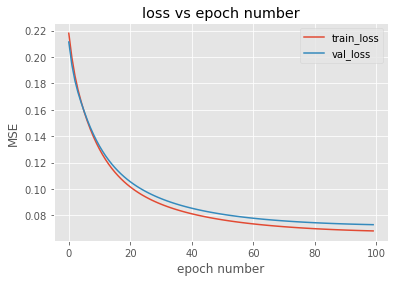

In [48]:
training_history = np.average([mdl.training_history for mdl in models], axis=0)
validation_history = np.average([mdl.validation_history for mdl in models], axis=0)

plot_loss(EPOCHS, training_history, validation_history)


# EVALUATION ON TEST DATASET

In [49]:
print("\nTest dataset evaluation:")
x_train_and_validation = under_sample_dataset[:, :-1]
y_train_and_validation = under_sample_dataset[:, -1:]

test_model = NeuralNetwork(learning_rate=LEARNING_RATE, batch_size=x_train_and_validation.shape[0], epochs=EPOCHS, loss='mse', regular_lambda=REGULARIZATION_LAMBDA)
test_model.add_layer(input_dim=NUMBER_OF_FEATURES, neurons_number=NUMBER_OF_NEURONS, activation='relu')
test_model.add_layer(input_dim=NUMBER_OF_NEURONS, neurons_number=1, activation='sigmoid')
test_model.fit(x_train_and_validation, y_train_and_validation)



Test dataset evaluation:
Loss:  0.199441441073  Accuracy:  0.6538461538461539
Loss:  0.184809108316  Accuracy:  0.6743589743589744
Loss:  0.17744508029  Accuracy:  0.6923076923076923
Loss:  0.170709673999  Accuracy:  0.7166666666666667
Loss:  0.164467766531  Accuracy:  0.7269230769230769
Loss:  0.1586819404  Accuracy:  0.7410256410256411
Loss:  0.153318140846  Accuracy:  0.7551282051282051
Loss:  0.148344455483  Accuracy:  0.7628205128205128
Loss:  0.143731083149  Accuracy:  0.7794871794871795
Loss:  0.1394501377  Accuracy:  0.791025641025641
Loss:  0.135475496344  Accuracy:  0.8025641025641026
Loss:  0.13178286616  Accuracy:  0.8102564102564103
Loss:  0.128349634545  Accuracy:  0.8256410256410256
Loss:  0.125154891713  Accuracy:  0.8307692307692308
Loss:  0.122179363736  Accuracy:  0.8346153846153846
Loss:  0.119405300779  Accuracy:  0.8448717948717949
Loss:  0.116816442368  Accuracy:  0.8487179487179487
Loss:  0.114397882104  Accuracy:  0.8589743589743589
Loss:  0.11213601132  Accur

In [50]:
test = pickle.load(open(os.path.join("..", "data", "test_dataset.data"), "rb" ))
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]
test_model.evaluate(x_test, y_test)
plot_confusion_matrix(model, x_test, y_test)
# print(model.layers[0].weights)

Loss:  0.0701891322517
Accuracy:  0.985025104455602

Precision: 0.09707724425887265
Recall: 0.9117647058823529
F-score: 0.17547169811320756


             actual 1  actual 0
predicted 1        93       865
predicted 0         9     55995


100%|██████████| 21/21 [01:22<00:00,  3.91s/it]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


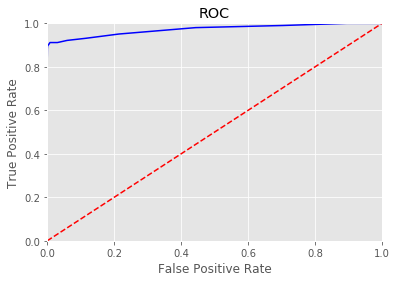

In [51]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    predicted = np.round(model.predict(x_test) + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)